# **Population-Level Sleep Pattern Analysis for Public Health**
## **Objective:**
to study how people’s sleep habits are different based on their age, gender, or lifestyle, and how sleep is connected to health problems like depression, obesity, and diabetes.

## **User Story**

As a **public health researcher**, I want to analyse sleep patterns across different age groups, genders, and lifestyles, so that I can understand how poor sleep is related to chronic health issues like depression, obesity, and diabetes, and recommend interventions at a population level.

## **Dataset**
- [NSRR- Sleep Heart Health Study](https://sleepdata.org/datasets/shhs/files)
- [Sleep-EDF](https://physionet.org/content/sleep-edfx/1.0.0/)

In [1]:
!pip install mne
!pip install xmltodict

## **Import libraries**

In [2]:
import mne, xmltodict
import matplotlib.pyplot as plt
import numpy as np, random
import pandas as pd
import os
from glob import glob
import re
from pathlib import Path
from collections import Counter
from google.colab import drive


import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset

from scipy.signal import butter, filtfilt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

## **Connect with google drive**

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Setting paths**

In [4]:
BASE = Path('/content/drive/MyDrive/NSRR_project')
BASE.exists(), BASE

(True, PosixPath('/content/drive/MyDrive/NSRR_project'))

In [5]:
edfs = sorted(glob(str(BASE / '*.edf')))
xmls = sorted(glob(str(BASE / '*.xml')))
print(len(edfs), 'EDF files')
print(len(xmls), 'XML files')
print(edfs[:3])
print(xmls[:3])


120 EDF files
122 XML files
['/content/drive/MyDrive/NSRR_project/SHHS 200001.edf', '/content/drive/MyDrive/NSRR_project/SHHS 200002.edf', '/content/drive/MyDrive/NSRR_project/SHHS 200003.edf']
['/content/drive/MyDrive/NSRR_project/SHHS 200001 Data.xml', '/content/drive/MyDrive/NSRR_project/SHHS 200002 Data.xml', '/content/drive/MyDrive/NSRR_project/SHHS 200003 Data.xml']


In [6]:
edfs = [Path(p) for p in glob(str(BASE / '*.edf'))]
xmls = [Path(p) for p in glob(str(BASE / '*.xml'))]

def subj_id(p: Path):
    """Extract 6-digit ID like 200001 from any filename."""
    m = re.search(r'(\d{6})', p.stem)
    return m.group(1) if m else None

edf_by_id = {subj_id(p): p for p in edfs if subj_id(p)}
xml_by_id = {}
for p in xmls:
    sid = subj_id(p)
    if sid and sid not in xml_by_id:
        xml_by_id[sid] = p

pairs = [(edf_by_id[i], xml_by_id[i]) for i in edf_by_id.keys() if i in xml_by_id]
print(f"Found {len(edfs)} EDFs, {len(xmls)} XMLs, {len(pairs)} paired.")

pairs[:3]

Found 120 EDFs, 122 XMLs, 120 paired.


[(PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200001.edf'),
  PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200001 Data.xml')),
 (PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200007.edf'),
  PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200007 Data.xml')),
 (PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200002.edf'),
  PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200002 Data.xml'))]

## **Loading the datasets**
### **Sources**
- **Demographics:** per-participant age, sex, BMI, lifestyle/health variables (e.g., smoking, diabetes, depression).
- **EDF (PSG signals):** overnight polysomnography recordings.
- **XML (annotations):** scored events aligned to the EDF timeline.



In [7]:
#choose the first pair
edf_path, xml_path = pairs[0]

raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)


with open(xml_path, 'rb') as f:
    d = xmltodict.parse(f.read())

events = d.get('PSGAnnotation', {}).get('ScoredEvents', {}).get('ScoredEvent', [])
if isinstance(events, dict): events = [events]

# parsed = []
# for ev in events:
#     concept = ev.get('EventConcept') or ev.get('Name') or ''
#     start = float(ev.get('Start', 0))
#     dur   = float(ev.get('Duration', 0))
#     parsed.append((concept, start, dur))

# print(f'Parsed {len(parsed)} events from XML (example):', parsed[:5])

EEG signals

Using matplotlib as 2D backend.


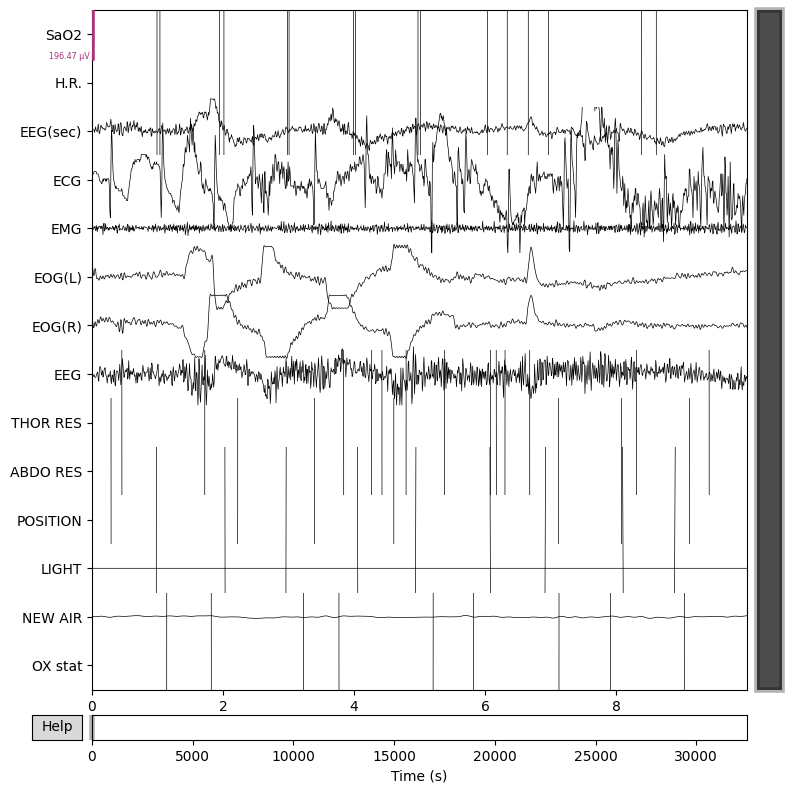

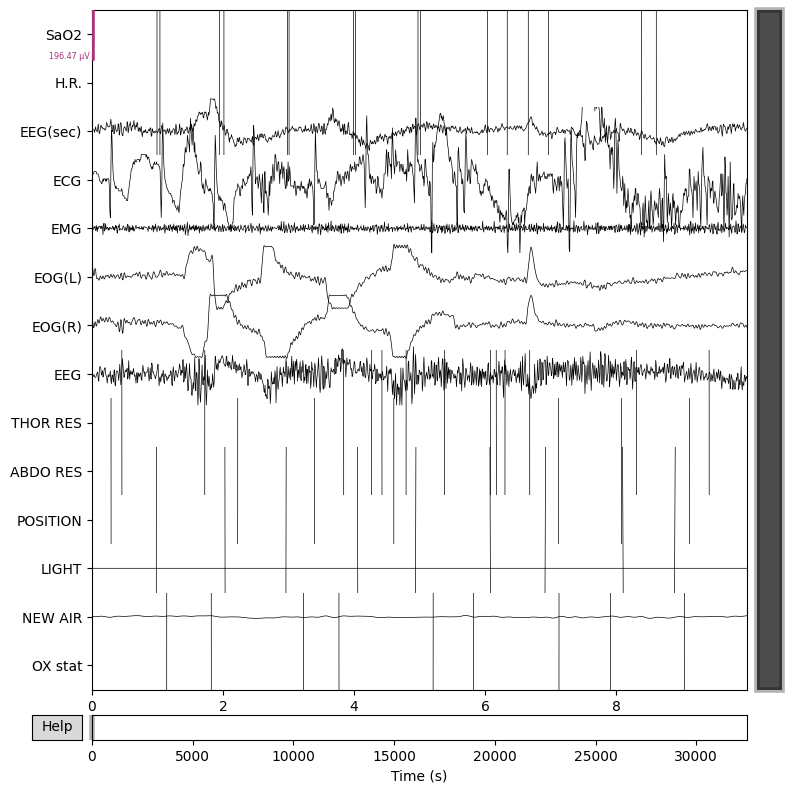

In [8]:
raw.plot(title="Raw EEG", scalings="auto", show=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


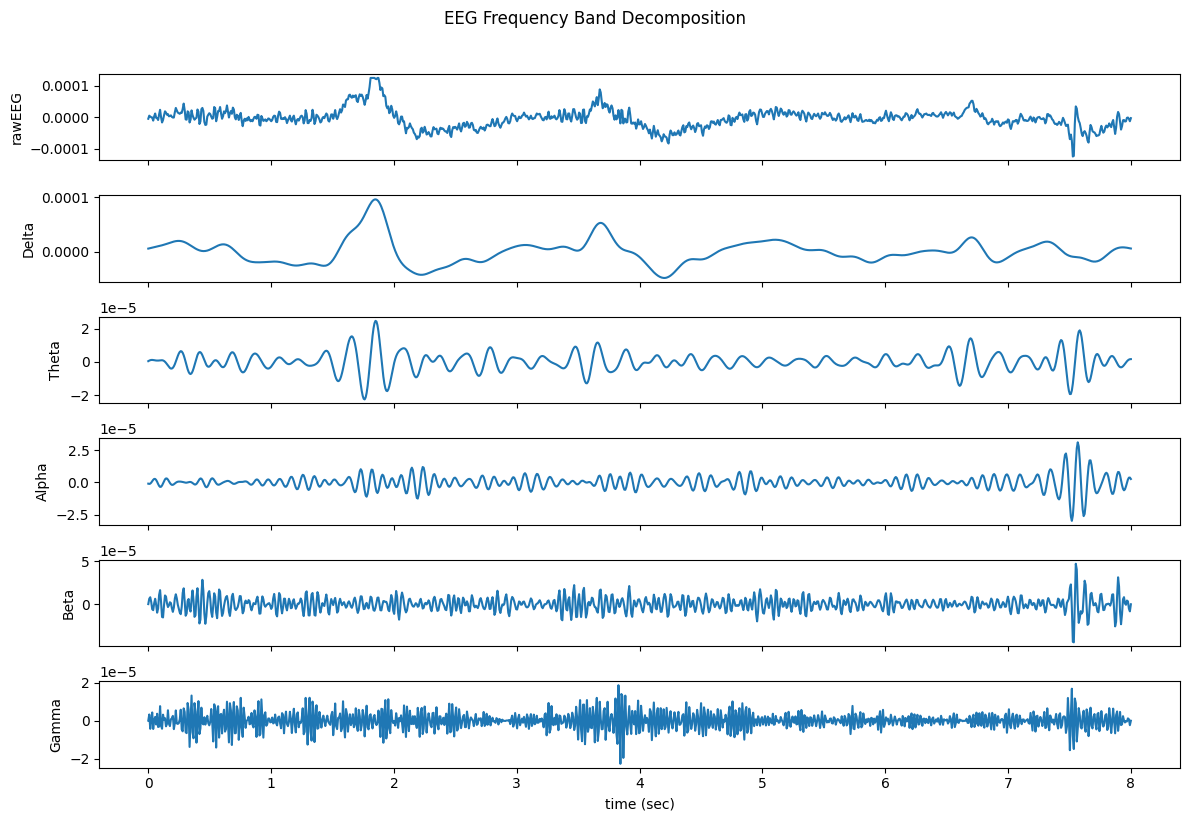

In [9]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low  = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y
# Use first EEG channel
eeg_ch = [ch for ch in raw.ch_names if 'EEG' in ch.upper()][0]
raw.pick_channels([eeg_ch])

# Sampling rate
fs = int(raw.info['sfreq'])

# Select 8 seconds from the signal
start_sec = 0
duration_sec = 8
start_sample = start_sec * fs
end_sample = start_sample + duration_sec * fs

signal, times = raw[:, start_sample:end_sample]
signal = signal[0]  # 1D
t = np.linspace(0, duration_sec, len(signal))

delta = bandpass_filter(signal, 0.5, 4, fs)
theta = bandpass_filter(signal, 4, 8, fs)
alpha = bandpass_filter(signal, 8, 13, fs)
beta  = bandpass_filter(signal, 13, 30, fs)
gamma = bandpass_filter(signal, 30, 50, fs)

fig, axs = plt.subplots(6, 1, figsize=(12, 8), sharex=True)

axs[0].plot(t, signal)
axs[0].set_ylabel('rawEEG')

axs[1].plot(t, delta)
axs[1].set_ylabel('Delta')

axs[2].plot(t, theta)
axs[2].set_ylabel('Theta')

axs[3].plot(t, alpha)
axs[3].set_ylabel('Alpha')

axs[4].plot(t, beta)
axs[4].set_ylabel('Beta')

axs[5].plot(t, gamma)
axs[5].set_ylabel('Gamma')
axs[5].set_xlabel('time (sec)')

plt.suptitle('EEG Frequency Band Decomposition', y=1.02)
plt.tight_layout()
plt.show()





### Understanding EEG Signals in Sleep Studies

EEG signals are recorded using small electrodes placed on the scalp. These electrodes detect brain waves, which are then amplified and visualized as waveforms. Each type of brain wave corresponds to different states of alertness or sleep.

### Common EEG Frequency Bands:
| Band  | Frequency (Hz) | Sleep Stage / Meaning         |
|-------|----------------|-------------------------------|
| Delta | 0.5–4 Hz       | Deep sleep (N3)               |
| Theta | 4–8 Hz         | Light sleep (N1, N2)          |
| Alpha | 8–13 Hz        | Relaxed wakefulness, drowsy   |
| Beta  | 13–30 Hz       | Wakefulness, REM sleep        |

During a full night’s sleep, EEG signals naturally shift across these bands as the person transitions through different sleep stages.

This project uses EEG data to:
- **Visualize sleep stages** over time (hypnogram)
- **Quantify time spent in each sleep stage**
- **Detect abnormal patterns** that may relate to health conditions like insomnia or sleep apnea


In [10]:
# build a clean events dataframe
rows = []
for ev in events if isinstance(events, list) else [events]:
    concept = (ev.get('EventConcept') or ev.get('Name') or '').strip()
    start   = float(ev.get('Start', 0.0))
    dur     = float(ev.get('Duration', 0.0))
    rows.append(dict(concept=concept, start_sec=start, duration_sec=dur, end_sec=start+dur))

ev_df = (pd.DataFrame(rows)
           .sort_values('start_sec')
           .assign(start_time=lambda d: pd.to_timedelta(d.start_sec, unit='s'),
                   end_time=lambda d: pd.to_timedelta(d.end_sec,   unit='s'))
           .reset_index(drop=True))

display(ev_df.head(20))
print("Events:", len(ev_df))


,concept,start_sec,duration_sec,end_sec,start_time,end_time
0,Recording Start Time,0.0,32520.0,32520.0,0 days 00:00:00,0 days 09:02:00
1,Wake|0,0.0,840.0,840.0,0 days 00:00:00,0 days 00:14:00
2,SpO2 artifact|SpO2 artifact,304.0,3.0,307.0,0 days 00:05:04,0 days 00:05:07
3,Stage 1 sleep|1,840.0,30.0,870.0,0 days 00:14:00,0 days 00:14:30
4,Stage 2 sleep|2,870.0,90.0,960.0,0 days 00:14:30,0 days 00:16:00
5,Wake|0,960.0,30.0,990.0,0 days 00:16:00,0 days 00:16:30
6,Arousal|Arousal (),964.8,25.4,990.2,0 days 00:16:04.800000,0 days 00:16:30.200000
7,Stage 1 sleep|1,990.0,30.0,1020.0,0 days 00:16:30,0 days 00:17:00
8,Stage 2 sleep|2,1020.0,270.0,1290.0,0 days 00:17:00,0 days 00:21:30
9,Stage 3 sleep|3,1290.0,120.0,1410.0,0 days 00:21:30,0 days 00:23:30


Events: 552


### **Polysomnography signals**

The dataset used in this study comes from the **Sleep Heart Health Study (NSRR)**, a large-scale, community-based cohort study investigating the relationship between sleep-disordered breathing and cardiovascular outcomes.  
The dataset contains **polysomnography (PSG)** recordings and accompanying demographic information.
| Column         | Meaning                                                                                  |
|----------------|-------------------------------------------------------------------------------------------|
| `concept`      | Event label (e.g., `Wake 0`, `Stage 1/2/3`, `REM`, `Arousal/Arousal ()`, `SpO2 artifact`). |
| `start_sec`    | Event start time in **seconds** from recording start.                                     |
| `duration_sec` | Event duration in seconds (sleep stages usually come in **30 s** blocks).                 |
| `end_sec`      | `start_sec + duration_sec`.                                                               |
| `start_time`   | Human-readable start time since recording start.                                          |
| `end_time`     | Human-readable end time since recording start.                                            |


In [11]:
meta_path = BASE / 'SHHS_Harmonized_Dataset.csv'
demo_data = pd.read_csv(meta_path, low_memory=False)
print("Shape:", demo_data.shape)
demo_data[101:].head(10)


Shape: (10115, 29)


,nsrrid,visitnumber,nsrr_age,nsrr_age_gt89,nsrr_sex,nsrr_race,nsrr_ethnicity,nsrr_bmi,nsrr_bp_systolic,nsrr_bp_diastolic,...,nsrr_ttleffsp_f1,nsrr_ttllatsp_f1,nsrr_ttlprdsp_s1sr,nsrr_ttldursp_s1sr,nsrr_ttldurws_f1,nsrr_pctdursp_s1,nsrr_pctdursp_s2,nsrr_pctdursp_s3,nsrr_pctdursp_sr,nsrr_ttlprdbd_f1
101,200102,1,47.0,no,female,white,not hispanic or latino,29.660457,110.0,80.0,...,83.52,8.0,68.5,67.0,73.0,1.83,53.84,23.87,20.46,491.5
102,200103,1,51.0,no,male,white,not hispanic or latino,31.309074,148.0,102.0,...,84.69,0.0,354.5,282.0,74.5,3.16,36.65,46.00,14.20,486.5
103,200104,1,71.0,no,female,white,not hispanic or latino,28.305995,150.0,90.0,...,48.19,21.5,59.0,59.0,193.0,6.02,47.37,22.31,24.31,414.0
104,200105,1,53.0,no,male,white,not hispanic or latino,25.982317,110.0,80.0,...,88.28,0.0,147.5,125.5,34.0,2.15,64.84,20.90,12.11,290.0
105,200106,1,54.0,no,male,white,not hispanic or latino,21.728997,110.0,72.0,...,80.97,0.0,44.0,30.5,90.0,4.96,60.57,1.04,33.42,473.0
106,200107,1,66.0,no,male,white,not hispanic or latino,21.886815,124.0,80.0,...,93.89,0.0,63.0,58.5,29.0,1.23,73.88,0.34,24.55,475.0
107,200108,1,60.0,no,female,white,not hispanic or latino,27.730121,100.0,70.0,...,84.60,22.5,171.0,141.5,43.5,3.31,59.72,15.59,21.38,428.5
108,200109,1,71.0,no,female,white,not hispanic or latino,24.161736,144.0,80.0,...,86.95,15.0,125.5,119.5,44.0,8.02,38.30,42.75,10.94,452.0
109,200110,1,58.0,no,male,white,not hispanic or latino,27.582177,112.0,64.0,...,94.06,0.0,40.5,40.0,24.5,2.96,83.76,0.90,12.37,412.5
110,200111,1,65.0,no,female,white,not hispanic or latino,23.802195,144.0,78.0,...,85.50,24.0,73.5,72.0,9.5,1.01,48.61,35.44,14.94,231.0


In [12]:
print("\nDtypes:\n", demo_data.dtypes.head(30))


Dtypes:
 nsrrid                    int64
visitnumber               int64
nsrr_age                float64
nsrr_age_gt89            object
nsrr_sex                 object
nsrr_race                object
nsrr_ethnicity           object
nsrr_bmi                float64
nsrr_bp_systolic        float64
nsrr_bp_diastolic       float64
nsrr_current_smoker      object
nsrr_ever_smoker         object
nsrr_ahi_hp3u           float64
nsrr_ahi_hp3r_aasm15    float64
nsrr_ahi_hp4u_aasm15    float64
nsrr_ahi_hp4r           float64
nsrr_ttldursp_f1        float64
nsrr_phrnumar_f1        float64
nsrr_flag_spsw           object
nsrr_ttleffsp_f1        float64
nsrr_ttllatsp_f1        float64
nsrr_ttlprdsp_s1sr      float64
nsrr_ttldursp_s1sr      float64
nsrr_ttldurws_f1        float64
nsrr_pctdursp_s1        float64
nsrr_pctdursp_s2        float64
nsrr_pctdursp_s3        float64
nsrr_pctdursp_sr        float64
nsrr_ttlprdbd_f1        float64
dtype: object


### **Demographic Data**
The SHHS (Sleep Heart Health Study) Harmonized Dataset is a cleaned and standardized version of the original SHHS data, curated by the NSRR (National Sleep Research Resource). This dataset combines key sleep and demographic information across multiple SHHS visits into a single, unified structure for analysis.

- **Dataset name**: SHHS Harmonized Dataset
- **Total rows (subjects)**: 10115
- **Total columns (variables)**: 29
- **ID field**: `nsrrid`



| Column Name            | Description                                  | Example       |
|------------------------|----------------------------------------------|---------------|
| `nsrr_age`             | Participant's age at time of visit           | `56`          |
| `nsrr_sex`             | Biological sex                               | `Male`        |
| `nsrr_bmi`             | Body Mass Index                              | `28.4`        |
| `nsrr_ahi_hp3u`        | Apnea-Hypopnea Index (recommended formula)   | `17.3`        |
| `nsrr_se_pct`          | Sleep efficiency (%)                         | `88.5`        |
| `nsrr_remdursp`        | REM sleep duration (minutes)                 | `79.2`        |

---


## **Data Wrangling Processing**

- Merged sleep information with demographic data using the subject ID (`sid6` or equivalent).
- Dropped unnecessary columns to reduce noise and improve model performance.
- Handled missing values by dropping rows with missing BMI, as only two rows were affected.



### **Demographic Data Preprocessing**

1. **Selected relevant features**  
   Extracted a subset of demographic columns from the dataset:
   - `nsrrid`: subject ID  
   - `nsrr_age`: participant's age  
   - `nsrr_sex`: biological sex  
   - `nsrr_bmi`: body mass index  
   - `nsrr_race`: race category  
   - `nsrr_current_smoker`: smoking status (current)

2. **Removed missing data**  
   Dropped any rows that had missing (`NaN`) values in the selected columns to ensure a clean input for modeling.

3. **Encoded categorical variables**
   - Converted the `nsrr_sex` column to binary:  
     - `male` → `0`  
     - `female` → `1`
   - Applied one-hot encoding to:
     - `nsrr_race` (e.g., White, Black, etc.)
     - `nsrr_current_smoker` (e.g., Yes, No)

4. **Normalized continuous features**  
   Scaled `nsrr_age` and `nsrr_bmi` to the range [0, 1] using **Min-Max scaling** to improve neural network performance.


In [13]:

demo = demo_data[['nsrrid','nsrr_age','nsrr_sex','nsrr_bmi','nsrr_race','nsrr_current_smoker']]
#clean missing values
demo = demo.dropna()
# Encode categorical
demo['nsrr_sex'] = demo['nsrr_sex'].map({'male':0,'female':1})
demo = pd.get_dummies(demo, columns=['nsrr_race','nsrr_current_smoker'])
#normalize
scaler = MinMaxScaler()
demo[['nsrr_age','nsrr_bmi']] = scaler.fit_transform(demo[['nsrr_age','nsrr_bmi']])


In [14]:
demo

,nsrrid,nsrr_age,nsrr_sex,nsrr_bmi,nsrr_race_black or african american,nsrr_race_other,nsrr_race_white,nsrr_current_smoker_no,nsrr_current_smoker_not reported,nsrr_current_smoker_yes
0,200001,0.313725,0,0.118049,False,False,True,True,False,False
1,200002,0.764706,0,0.467209,False,False,True,True,False,False
2,200003,0.745098,1,0.191067,False,False,True,True,False,False
3,200004,0.176471,0,0.068287,False,False,True,True,False,False
4,200005,0.529412,1,0.165908,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
10109,205797,0.411765,1,0.138352,False,False,True,True,False,False
10110,205798,0.490196,0,0.400134,False,False,True,True,False,False
10111,205799,0.392157,1,0.470613,False,False,True,True,False,False
10112,205800,0.627451,0,0.263092,False,False,True,True,False,False


### **Sleep Event Parsing to Epoch-Level Hypnogram**

This step processes raw event annotations (from `.xml`) into a regular time series of sleep stages (a hypnogram), suitable for sequence models like LSTM.

1. **Sleep Stage Mapping**
   - A custom `concept_to_stage_id()` function maps SHHS/NSRR sleep labels to standard stage IDs:
     - `0 = Wake`, `1 = N1`, `2 = N2`, `3 = N3` (includes N4), `4 = REM`
   - It ignores non-sleep-stage events like apneas, arousals, artifacts, or sensor signals.

2. **Epoch Length Detection**
   - Estimates the epoch duration by taking the median duration of valid stage events (e.g., 30s), and clamps it between 20–60 seconds.
   - If no stage events are found, defaults to 30s.

3. **Timeline Initialization**
   - Computes the total sleep recording duration from the earliest start to the latest end.
   - Divides the total duration into uniform epochs (e.g., 30s per epoch).
   - Initializes the full hypnogram as Wake (`0`) by default.

4. **Sleep Stage Assignment**
   - Iterates through each sleep stage event and fills in the corresponding epochs with its stage ID.
   - Handles partial overlaps and ensures at least one epoch is marked per event.

5. **Output: Hypnogram DataFrame**
   - Constructs a clean `hypno_df` that contains:
     - `epoch` index
     - `start/end times` (in seconds)
     - `stage_id` (0–4)
     - `stage_name` ('W', 'N1', etc.)
   - Also returns `seq` as a NumPy array of stage IDs and `meta` containing useful metadata like epoch length and total duration.

This step ensures that your raw annotations are converted into a **fixed-length time series of sleep stages**, which is a crucial input for time-based models like LSTM.


In [15]:

# Map many SHHS/NSRR concept strings to {0..4}
def concept_to_stage_id(concept: str) -> int | None:
    """
    Returns stage id: 0=W,1=N1,2=N2,3=N3,4=REM; or None for non-stage events.
    Handles common NSRR/SHHS variants like 'Wakel0', 'Stage 2 sleep|2', 'REM sleep|R'.
    """
    if not isinstance(concept, str):
        return None
    c = concept.lower()

    # quick exits for non-stage keywords
    non_stage_hits = [
        'arousal', 'hypopnea', 'apnea', 'desaturation', 'artifact',
        'sp02', 'spo2', 'periodic limb', 'plm', 'rera', 'snore',
        'tech', 'position', 'recording start', 'recording end'
    ]
    if any(k in c for k in non_stage_hits):
        return None

    # W
    if 'wake' in c or c.strip() in {'w', 'wake|0', 'wakel0', 'w|0'}:
        return 0

    # REM
    if 'rem' in c or c.strip() in {'rem sleep|r', 'r', 'r|rem'}:
        return 4

    # Stage/N labels (handle "Stage 1 sleep|1", "N1", etc.)
    if 'stage 1' in c or ' n1' in f' {c} ' or c.strip() in {'n1','1','1|n1'}:
        return 1
    if 'stage 2' in c or ' n2' in f' {c} ' or c.strip() in {'n2','2','2|n2'}:
        return 2
    if 'stage 3' in c or ' n3' in f' {c} ' or c.strip() in {'n3','3','3|n3'}:
        return 3
    if 'stage 4' in c or ' n4' in f' {c} ' or c.strip() in {'n4','4','4|n4'}:
        # Modern scoring merges N3+N4
        return 3

    return None  # not a sleep-stage event


def build_hypnogram(ev_df: pd.DataFrame, epoch_sec: int | None = None):
    """
    Build epoch-level hypnogram from event rows.
    Returns:
      seq: np.ndarray of shape [T] with stage ids {0..4}
      hypno_df: DataFrame with epoch metadata (epoch_idx, t_start_sec, t_end_sec, stage_id, stage_name)
      meta: dict with useful info (epoch_sec, total_secs, n_epochs)
    """
    # 1) keep only rows with parsable times
    df = ev_df.copy()
    for col in ['start_sec', 'end_sec', 'duration_sec']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['start_sec', 'end_sec'])

    # 2) determine epoch length (default to median of labeled stage events; fallback=30s)
    stage_rows = []
    for _, r in df.iterrows():
        sid = concept_to_stage_id(r['concept'])
        if sid is not None:
            stage_rows.append(r)

    stg_df = pd.DataFrame(stage_rows) if len(stage_rows) else pd.DataFrame(columns=df.columns)

    if epoch_sec is None:
        if len(stg_df):
            # typical SHHS is 30s epochs; still compute a robust guess and clamp to [20, 60]
            dur_median = np.nanmedian(stg_df['duration_sec'].values)
            epoch_sec = int(np.clip(round(dur_median) if np.isfinite(dur_median) else 30, 20, 60))
        else:
            epoch_sec = 30

    # 3) establish timeline bounds
    if len(stg_df):
        t0 = float(np.nanmin(stg_df['start_sec'].values))
        t1 = float(np.nanmax(stg_df['end_sec'].values))
    else:
        # fall back to all events if no stages found
        t0 = float(np.nanmin(df['start_sec'].values))
        t1 = float(np.nanmax(df['end_sec'].values))

    # ensure sane bounds
    t0 = max(0.0, t0)
    total_secs = max(0.0, t1 - t0)
    n_epochs = int(np.ceil(total_secs / epoch_sec)) if total_secs > 0 else 0

    # 4) initialize sequence as Wake (0)
    seq = np.zeros(n_epochs, dtype=np.int8)

    # 5) paint stage labels across epochs
    for _, r in stg_df.iterrows():
        sid = concept_to_stage_id(r['concept'])
        if sid is None:
            continue
        s = int(np.floor((r['start_sec'] - t0) / epoch_sec))
        e = int(np.ceil((r['end_sec']   - t0) / epoch_sec))
        s = max(0, s)
        e = min(n_epochs, max(s + 1, e))  # ensure at least one epoch if overlaps
        seq[s:e] = sid

    # 6) package a tidy hypnogram dataframe
    epoch_idx = np.arange(n_epochs)
    t_starts = t0 + epoch_idx * epoch_sec
    t_ends   = t_starts + epoch_sec

    stage_names = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    hypno_df = pd.DataFrame({
        'epoch': epoch_idx,
        't_start_sec': t_starts,
        't_end_sec': t_ends,
        'stage_id': seq.astype(int),
        'stage_name': [stage_names[int(x)] for x in seq]
    })

    meta = dict(epoch_sec=epoch_sec, total_secs=total_secs, n_epochs=n_epochs, t0=t0, t1=t1)

    return seq, hypno_df, meta


seq, hypno_df, meta = build_hypnogram(ev_df)

print(f"Epoch length: {meta['epoch_sec']} sec  |  Total secs: {meta['total_secs']:.0f}  |  #epochs: {meta['n_epochs']}")
print("Stage counts:", Counter(seq.tolist()))
print(hypno_df.head())



Epoch length: 60 sec  |  Total secs: 32520  |  #epochs: 542
Stage counts: Counter({2: 227, 0: 162, 3: 75, 4: 52, 1: 26})
   epoch  t_start_sec  t_end_sec  stage_id stage_name
0      0          0.0       60.0         0          W
1      1         60.0      120.0         0          W
2      2        120.0      180.0         0          W
3      3        180.0      240.0         0          W
4      4        240.0      300.0         0          W


In [16]:
hypno_df.shape

(542, 5)

In [17]:
def plot_hypnogram(hypno_df):
    # Map stage labels for better visual order (higher stages lower on Y-axis)
    stage_map = {'W': 0, 'REM': 1, 'N1': 2, 'N2': 3, 'N3': 4}
    y = hypno_df['stage_name'].map(stage_map)

    x = hypno_df['t_start_sec'] / 60  # convert to minutes for x-axis

    plt.figure(figsize=(12, 4))
    plt.step(x, y, where='post', linewidth=1.5)
    plt.yticks(ticks=list(stage_map.values()), labels=list(stage_map.keys())[::-1])  # Flip for sleep stage depth
    plt.gca().invert_yaxis()  # Deeper stages at bottom

    plt.title(f"Hypnogram")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Sleep Stage")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


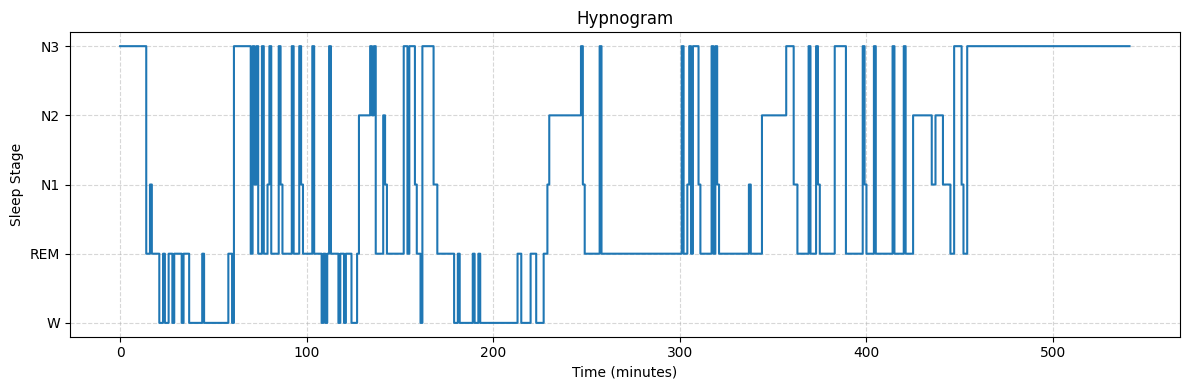

In [18]:
plot_hypnogram(hypno_df)


### **Sleep Data + Demographics Integration Pipeline**

This step processes raw PSG data and harmonized demographics into model-ready arrays for each subject.


#### 1. **Pair EDF and XML Files by Subject**
- Extracts a 6-digit subject ID (`sid6`) from each `.edf` and `.xml` filename.
- Matches `.edf` and `.xml` files for subjects that have both.
- Creates a `pairs_df` dataframe with file paths and subject IDs.

#### 2. **Join with Demographics**
- Loads the harmonized demographics CSV (`SHHS_Harmonized_Dataset.csv`).
- Extracts `sid6` from the `nsrrid` field for joining.
- Merges file paths with demographic rows using `sid6`.
- Filters and retains only desired demographic fields (age, sex, BMI, etc.).

#### 3. **Parse Sleep Stage Events**
- For each subject:
  - Loads XML event annotations using `xmltodict`.
  - Parses each row (e.g., `"Stage 2 sleep|2"`, `"Wake|0"`) into a stage ID using the `build_hypnogram()` function.
  - Converts irregular duration annotations into a **fixed-length sequence** of stage IDs (epoch-level hypnogram).
  - Pads or truncates each hypnogram to 1200 epochs (~10 hours at 30s resolution).



#### 4. **Process Demographics**
- Extracts key variables (age, BMI, gender, hypertension, etc.) into a clean dictionary per subject.
- Encodes categorical variables:
  - `gender` → binary (female = 1)
  - `smoking`, `hypertension`, `diabetes` → converted to binary flags
- Scales continuous variables (`age`, `BMI`) using Min-Max normalization to [0, 1].


#### 5. **Build Model Inputs**
- Constructs:
  - `X_seq`: array of shape `(N, 1200, 1)` — padded hypnograms per subject
  - `X_demo`: array of shape `(N, F)` — normalised demographic features
  - `subject_table`: table linking `sid6` and fallback `nsrrid` for reference
- Ready to be used in PyTorch models with LSTM + tabular MLP branches.


This entire pipeline prepares **clean, synchronised time-series + demographic data** for each subject, enabling robust downstream modelling of sleep patterns and their associations with health conditions.


In [19]:


BASE = Path(BASE)

edfs = [Path(p) for p in glob(str(BASE/'*.edf'))]
xmls = [Path(p) for p in glob(str(BASE/'*.xml'))]

def sid6_from_name(p: Path):
    """Extract 6-digit SHHS id from filenames like 'shhs1-000123.edf', '200123.edf', etc."""
    m = re.search(r'(\d{6})', p.stem)
    return m.group(1) if m else None

edf_by_id = {sid6_from_name(p): p for p in edfs if sid6_from_name(p)}
xml_by_id = {}
for p in xmls:
    sid = sid6_from_name(p)
    if sid and sid not in xml_by_id:
        xml_by_id[sid] = p

pairs = [{'sid6': k, 'edf_path': str(edf_by_id[k]), 'xml_path': str(xml_by_id[k])}
         for k in edf_by_id.keys() if k in xml_by_id]
pairs_df = pd.DataFrame(pairs).sort_values('sid6').reset_index(drop=True)
print("Paired files:", pairs_df.shape)
display(pairs_df.head(3))

# ---- add sid6 to demographics and join ----
# example demographic file path:
meta_path = BASE / 'SHHS_Harmonized_Dataset.csv'  # or your path
demo_data = pd.read_csv(meta_path, low_memory=False)

# add 6-digit id from 'nsrrid' (e.g., nsrrid = 'shhs1-000123' -> sid6='000123')
if 'nsrrid' not in demo_data.columns:
    raise ValueError("Your demographics file must contain an 'nsrrid' column.")

demo_data['sid6'] = demo_data['nsrrid'].astype(str).str.extract(r'(\d{6})$')

# optional: pick demo columns you want (auto-intersect so it won't crash)
wanted_demo_cols = ['nsrrid','sid6','age_s1','gender','bmi_s1','race','smoking','hypertension','diabetes']
demo_cols = [c for c in wanted_demo_cols if c in demo_data.columns]
demo_slim = demo_data[demo_cols].copy()

# left-join pairs to demographics using sid6
pairs_joined = pairs_df.merge(demo_slim, on='sid6', how='left')
print("Pairs with demographics:", pairs_joined.shape)
print("Missing demo rows:", pairs_joined['nsrrid'].isna().sum())
display(pairs_joined.head(5))

# ---------- build sequences + merge with demo for MANY subjects ----------
# assumes you already defined build_hypnogram(ev_df) from Step 3

import mne, xmltodict

def load_events_from_xml(xml_path: str) -> pd.DataFrame:
    with open(xml_path, 'rb') as f:
        d = xmltodict.parse(f.read())
    events = d.get('PSGAnnotation', {}).get('ScoredEvents', {}).get('ScoredEvent', [])
    if isinstance(events, dict):
        events = [events]

    rows = []
    for ev in events if isinstance(events, list) else [events]:
        concept = (ev.get('EventConcept') or ev.get('Name') or '').strip()
        start   = float(ev.get('Start', 0.0))
        dur     = float(ev.get('Duration', 0.0))
        rows.append(dict(concept=concept, start_sec=start, duration_sec=dur, end_sec=start+dur))
    ev_df = (pd.DataFrame(rows)
             .sort_values('start_sec')
             .assign(start_time=lambda d: pd.to_timedelta(d.start_sec, unit='s'),
                     end_time=lambda d: pd.to_timedelta(d.end_sec,   unit='s'))
             .reset_index(drop=True))
    return ev_df

# pad/truncate to fixed length for batching
MAX_EPOCHS = 1200  # ~10h @ 30s/epoch; adjust if your Step 3 inferred 60s, it's still fine
def pad_sequence(seq, max_len=MAX_EPOCHS, pad_value=0):
    out = np.full(max_len, pad_value, dtype=np.int64)
    L = min(len(seq), max_len)
    out[:L] = seq[:L]
    return out

# basic demo processing (encode/scale quickly; refine later)
from sklearn.preprocessing import MinMaxScaler

def prepare_demo_row(row: pd.Series):
    d = {}
    if 'age_s1' in row: d['age_s1'] = row['age_s1']
    if 'bmi_s1' in row: d['bmi_s1'] = row['bmi_s1']
    # gender -> {male:0, female:1} if present
    if 'gender' in row:
        g = str(row['gender']).strip().lower()
        d['gender_female'] = 1 if g in ['female','f','1'] else 0
    # simple binary flags if exist
    for col in ['hypertension','diabetes','smoking']:
        if col in row:
            v = str(row[col]).strip().lower()
            d[col] = 1 if v in ['1','yes','true','y','current','ever'] else 0
    return d

seq_bank = []
demo_bank = []
id_bank = []

for ix, r in pairs_joined.iterrows():
    # load XML events
    ev_df = load_events_from_xml(r['xml_path'])
    # build hypnogram (uses your function from Step 3)
    seq, hypno_df, meta = build_hypnogram(ev_df)  # epoch_sec may be 30 or 60 depending on file
    seq_bank.append(pad_sequence(seq))
    # prepare demographics vector
    demo_vec = prepare_demo_row(r)
    demo_bank.append(demo_vec)
    id_bank.append(r.get('nsrrid') if pd.notna(r.get('nsrrid')) else f"shhs?-{r['sid6']}")

# align demo dicts to the same column order
demo_columns = sorted({k for d in demo_bank for k in d.keys()})
demo_mat = np.array([[d.get(c, 0.0) for c in demo_columns] for d in demo_bank], dtype=np.float32)

# scale continuous columns (keep binaries as is)
cont_cols = [c for c in demo_columns if any(k in c for k in ['age','bmi'])]
if cont_cols:
    scaler = MinMaxScaler()
    j = [demo_columns.index(c) for c in cont_cols]
    demo_mat[:, j] = scaler.fit_transform(demo_mat[:, j])

X_seq  = np.array(seq_bank, dtype=np.int64)[:, :, None]  # (N, T, 1)
X_demo = demo_mat                                      # (N, F)
subject_table = pd.DataFrame({'nsrrid_fallback': id_bank, 'sid6': pairs_joined['sid6']})

# Make sure 'nsrr_ttleffsp_f1' exists in your original demo_data
if 'nsrr_ttleffsp_f1' not in demo_data.columns:
    raise ValueError("Target column 'nsrr_ttleffsp_f1' not found in demographics file")

# Map sid6 to sleep efficiency using original demo_data
target_map = demo_data.set_index('sid6')['nsrr_ttleffsp_f1'].to_dict()
y = np.array([target_map.get(sid, np.nan) for sid in subject_table['sid6']], dtype=np.float32)

# Drop samples with missing target
valid = ~np.isnan(y)
X_seq = X_seq[valid]
X_demo = X_demo[valid]
y = y[valid]


print("X_seq shape:", X_seq.shape)
print("X_demo shape:", X_demo.shape)
print("Subjects prepared:", len(id_bank))
display(subject_table.head(10))


Paired files: (120, 3)


,sid6,edf_path,xml_path
0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...
1,200002,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...
2,200003,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...


Pairs with demographics: (175, 4)
Missing demo rows: 0


,sid6,edf_path,xml_path,nsrrid
0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200001
1,200002,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200002
2,200003,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200003
3,200004,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200004
4,200004,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200004


X_seq shape: (113, 1200, 1)
X_demo shape: (113, 0)
Subjects prepared: 175


,nsrrid_fallback,sid6
0,200001,200001
1,200002,200002
2,200003,200003
3,200004,200004
4,200004,200004
5,200005,200005
6,200006,200006
7,200006,200006
8,200007,200007
9,200007,200007


In [20]:
print(demo_data.shape)
print(demo_data.columns[:20])


(10115, 30)
Index(['nsrrid', 'visitnumber', 'nsrr_age', 'nsrr_age_gt89', 'nsrr_sex',
       'nsrr_race', 'nsrr_ethnicity', 'nsrr_bmi', 'nsrr_bp_systolic',
       'nsrr_bp_diastolic', 'nsrr_current_smoker', 'nsrr_ever_smoker',
       'nsrr_ahi_hp3u', 'nsrr_ahi_hp3r_aasm15', 'nsrr_ahi_hp4u_aasm15',
       'nsrr_ahi_hp4r', 'nsrr_ttldursp_f1', 'nsrr_phrnumar_f1',
       'nsrr_flag_spsw', 'nsrr_ttleffsp_f1'],
      dtype='object')


**Shape Consistency**

In [21]:
print("X_seq shape:", X_seq.shape)
print("X_demo shape:", X_demo.shape)
print("y shape:", y.shape)


X_seq shape: (113, 1200, 1)
X_demo shape: (113, 0)
y shape: (113,)


**Check for Missing or Invalid Values**

In [22]:
assert not np.isnan(X_seq).any(), "NaN found in X_seq"
assert not np.isnan(X_demo).any(), "NaN found in X_demo"
assert not np.isnan(y).any(), "NaN found in y"


In [23]:


# # choose columns to use as predictors
# demo_cols = [
#     'nsrrid', 'sid6',         # keep IDs
#     'nsrr_age', 'nsrr_sex', 'nsrr_race', 'nsrr_ethnicity',
#     'nsrr_bmi', 'nsrr_bp_systolic', 'nsrr_bp_diastolic',
#     'nsrr_current_smoker', 'nsrr_ever_smoker','nsrr_ttleffsp_f1','nsrr_ahi_hp3u', 'nsrr_ahi_hp3r_aasm15',
#                         'nsrr_ahi_hp4u_aasm15', 'nsrr_ahi_hp4r'
# ]

# demo_slim = demo_data[[c for c in demo_cols if c in demo_data.columns]].copy()

# # join with pairs_df again
# pairs_joined = pairs_df.merge(demo_slim, on='sid6', how='left')

# # ----- process features -----
# demo_features = []

# for _, row in pairs_joined.iterrows():
#     d = {}
#     # continuous
#     d['age'] = row.get('nsrr_age', np.nan)
#     d['bmi'] = row.get('nsrr_bmi', np.nan)
#     d['bp_sys'] = row.get('nsrr_bp_systolic', np.nan)
#     d['bp_dia'] = row.get('nsrr_bp_diastolic', np.nan)

#     # categorical / binary
#     d['sex_female'] = 1 if str(row.get('nsrr_sex')).lower().startswith('f') else 0
#     d['race'] = row.get('nsrr_race', np.nan)   # could one-hot encode
#     d['ethnicity'] = row.get('nsrr_ethnicity', np.nan)
#     d['smoker_current'] = 1 if str(row.get('smoker_current')).lower().startswith('y') else 0
#     d['smoker_ever'] = 1 if str(row.get('smoker_ever')).lower().startswith('y') else 0

#     demo_features.append(d)

# demo_df = pd.DataFrame(demo_features)

# # handle race/ethnicity with one-hot encoding
# demo_df = pd.get_dummies(demo_df, columns=['race','ethnicity'], dummy_na=True)

# # scale continuous columns
# scaler = MinMaxScaler()
# cont_cols = ['age','bmi','bp_sys','bp_dia']
# demo_df[cont_cols] = scaler.fit_transform(demo_df[cont_cols])

# X_demo = demo_df.values.astype(np.float32)
# print("X_demo shape:", X_demo.shape)


### **Feature Engineering – Sleep Stage-Based Features**

To enhance the model with meaningful sleep characteristics, we engineered new features from each subject’s hypnogram (`seq`), which represents the sequence of sleep stages across the night. These features aim to summarise the subject’s sleep quality, sleep architecture, and wake patterns.

**Extracted Features per Subject**

For each subject, we computed the following metrics:

- **pct_W, pct_N1, pct_N2, pct_N3, pct_REM**: Proportion of time spent in each sleep stage.
- **pct_deep**: Combined percentage of deep sleep stages (N3 and REM).
- **waso_min**: Wake After Sleep Onset — total minutes spent awake after initially falling asleep.
- **n_wake_episodes**: Number of distinct wake blocks throughout the night.
- **sleep_eff**: Approximate sleep efficiency, defined as 1 − pct_W.

These features were derived from the raw sleep stage sequences using custom logic (e.g., segmenting wake runs, identifying sleep onset index).

**Scaling**

We applied **MinMaxScaler** to normalise the stage-derived features into a consistent 0–1 range. This ensures compatibility with neural network training and avoids dominance by features with larger numeric ranges.

**Integration**

The stage-based features were horizontally concatenated with the previously cleaned and encoded demographic features (`X_demo`). The resulting enriched matrix (`X_demo_enriched`) better represents both **sleep physiology** and **subject characteristics**, supporting stronger model generalisation.



In [24]:
# def compute_stage_features(seq: np.ndarray, epoch_sec: int = 30) -> dict:
#     """
#     Given a subject's hypnogram sequence, return sleep stage percentages and derived features.
#     Assumes stage IDs: {0:W, 1:N1, 2:N2, 3:N3, 4:REM}
#     """
#     d = {}
#     total_epochs = len(seq)
#     if total_epochs == 0:
#         return {k: 0.0 for k in ['pct_W','pct_N1','pct_N2','pct_N3','pct_REM','pct_deep','n_wake_episodes','waso_min','sleep_eff']}

#     stage_counts = np.bincount(seq, minlength=5)
#     d['pct_W']   = stage_counts[0] / total_epochs
#     d['pct_N1']  = stage_counts[1] / total_epochs
#     d['pct_N2']  = stage_counts[2] / total_epochs
#     d['pct_N3']  = stage_counts[3] / total_epochs
#     d['pct_REM'] = stage_counts[4] / total_epochs
#     d['pct_deep'] = d['pct_N3'] + d['pct_REM']  # optional

#     # Wake After Sleep Onset (WASO): count Wake epochs *after* first N1/N2/N3/REM
#     sleep_onset_idx = np.where(np.isin(seq, [1,2,3,4]))[0]
#     if len(sleep_onset_idx):
#         after_onset = seq[sleep_onset_idx[0]:]
#         d['waso_min'] = np.sum(after_onset == 0) * (epoch_sec / 60.0)
#     else:
#         d['waso_min'] = 0.0

#     # Number of Wake episodes (>=1 consecutive Wake blocks)
#     wake_runs = np.split(seq, np.where(seq != 0)[0])
#     d['n_wake_episodes'] = sum(1 for run in wake_runs if len(run) and np.all(run == 0))

#     # Sleep efficiency = 1 - (wake %)
#     d['sleep_eff'] = 1.0 - d['pct_W']

#     return d


In [25]:
# stage_feature_list = [compute_stage_features(seq.squeeze()) for seq in X_seq]
# df_stages = pd.DataFrame(stage_feature_list)

# # Scale numeric stage features (optional but recommended)
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_stages[df_stages.columns] = scaler.fit_transform(df_stages)

# # Combine with existing X_demo
# X_demo_enriched = np.hstack([X_demo, df_stages.values])
# print("New shape with stage features:", X_demo_enriched.shape)


In [26]:
# df_stages

## **Train–Validation–Test Split**

After preparing the combined dataset of **sleep stage sequences** (`X_seq`) and **demographic features** (`X_demo_enriched`), we split the data into three parts to support model development:

**Purpose of Each Split**

- **Training Set**: Used to fit the model weights and learn patterns.
- **Validation Set**: Used to fine-tune hyperparameters and monitor generalisation to unseen data.
- **Test Set**: Used only at the end to evaluate final model performance.

 **Method Used**

- We use `train_test_split` from `sklearn.model_selection` to create these splits.
- First, we reserve **15% of data for testing**.
- Then, from the remaining 85%, we take **15% for validation** (~12.75% of original).
- This results in an approximate 72.25% / 12.75% / 15% split across Train / Val / Test.

**Features and Labels Split**

The following data structures are split in a **synchronized** manner:

- `X_seq`: sleep stage time-series data (e.g., shape: `(N, T, 1)`)
- `X_demo_enriched`: processed demographic + hypnogram summary features (shape: `(N, F)`)
- `y`: target variable (e.g., sleep efficiency or AHI severity class)




In [27]:

X_seq_tv, X_seq_te, X_demo_tv, X_demo_te, y_tv, y_te = train_test_split(
    X_seq, X_demo, y, test_size=0.2, random_state=42
)

X_seq_tr, X_seq_va, X_demo_tr, X_demo_va, y_tr, y_va = train_test_split(
    X_seq_tv, X_demo_tv, y_tv, test_size=0.2, random_state=42
)

print(f"Train: X_seq {X_seq_tr.shape}, X_demo {X_demo_tr.shape}, y {y_tr.shape}")
print(f"Val:   X_seq {X_seq_va.shape}, X_demo {X_demo_va.shape}, y {y_va.shape}")
print(f"Test:  X_seq {X_seq_te.shape}, X_demo {X_demo_te.shape}, y {y_te.shape}")


Train: X_seq (72, 1200, 1), X_demo (72, 0), y (72,)
Val:   X_seq (18, 1200, 1), X_demo (18, 0), y (18,)
Test:  X_seq (23, 1200, 1), X_demo (23, 0), y (23,)


## **Model building**

The `SleepRegressor` is a **deep learning model** designed to predict sleep efficiency (`nsrr_ttleffsp_f1`) by combining information from:
- Sleep stage sequences (`x_seq`) per subject
- Demographic features (`x_demo`)

### Architecture Details:

1. **LSTM Layer (`self.lstm`)**
   - **Input**: A sequence of sleep stages over time (shape: `[batch_size, time_steps, 1]`)
   - **Purpose**: Captures **temporal dependencies** and patterns in sleep stages
   - **Output**: The last hidden state `h_seq` of shape `[batch_size, hidden_dim]`

2. **Fully Connected Layer for Demographics (`self.demo_fc`)**
   - **Input**: A vector of demographic features (e.g., age, BMI, smoking)
   - **Purpose**: Projects the demographic vector to the same hidden dimension as the LSTM output
   - **Output**: `h_demo` of shape `[batch_size, hidden_dim]`

3. **Concatenation + Final Linear Layer (`self.out`)**
   - **Step**: Concatenate `h_seq` and `h_demo` → `[batch_size, hidden_dim * 2]`
   - **Final Output**: A single regression output per sample → `[batch_size, 1]`


In [28]:
class SleepRegressor(nn.Module):
    def __init__(self, input_dim=1, demo_dim=15, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.demo_fc = nn.Linear(demo_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x_seq, x_demo):
        _, (h_n, _) = self.lstm(x_seq)  # h_n: [1, batch, hidden]
        h_seq = h_n.squeeze(0)
        h_demo = self.demo_fc(x_demo)
        h = torch.cat([h_seq, h_demo], dim=1)
        return self.out(h)


### **Create DataLoader**

In [29]:


# Convert numpy arrays to PyTorch tensors
X_seq_torch  = torch.tensor(X_seq, dtype=torch.float32)   # (N, T, 1)
X_demo_torch = torch.tensor(X_demo, dtype=torch.float32)  # (N, F)
y_torch      = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # (N, 1)

# Train/val/test split
from sklearn.model_selection import train_test_split
X_seq_tr, X_seq_te, X_demo_tr, X_demo_te, y_tr, y_te = train_test_split(X_seq_torch, X_demo_torch, y_torch, test_size=0.2, random_state=42)
X_seq_tr, X_seq_va, X_demo_tr, X_demo_va, y_tr, y_va = train_test_split(X_seq_tr, X_demo_tr, y_tr, test_size=0.2, random_state=42)

# Wrap in DataLoader
BATCH_SIZE = 32

train_ds = TensorDataset(X_seq_tr, X_demo_tr, y_tr)
val_ds   = TensorDataset(X_seq_va, X_demo_va, y_va)
test_ds  = TensorDataset(X_seq_te, X_demo_te, y_te)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)


### **Initialise Model**

In [30]:
model = SleepRegressor(input_dim=1, demo_dim=X_demo.shape[1], hidden_dim=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

/usr/local/lib/python3.12/dist-packages/torch/nn/init.py:582: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


### **Model Training**

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # ⬇️ store history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_mae': [], 'val_mae': []
    }

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        y_train_true, y_train_pred = [], []

        for x_seq, x_demo, y_true in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_seq, x_demo)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            y_train_true.extend(y_true.cpu().detach().numpy())
            y_train_pred.extend(y_pred.cpu().detach().numpy())

        model.eval()
        val_losses = []
        y_val_true, y_val_pred = [], []

        with torch.no_grad():
            for x_seq, x_demo, y_true in val_loader:
                y_pred = model(x_seq, x_demo)
                loss = criterion(y_pred, y_true)
                val_losses.append(loss.item())
                y_val_true.extend(y_true.cpu().numpy())
                y_val_pred.extend(y_pred.cpu().numpy())

        train_mae = mean_absolute_error(y_train_true, y_train_pred)
        val_mae = mean_absolute_error(y_val_true, y_val_pred)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        # Save to history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} MAE: {train_mae:.4f} | "
              f"Val Loss: {val_loss:.4f} MAE: {val_mae:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, history


In [32]:
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5)


Epoch 01 | Train Loss: 6706.7725 MAE: 81.5687 | Val Loss: 5924.7178 MAE: 75.9715
Epoch 02 | Train Loss: 6902.3260 MAE: 81.5226 | Val Loss: 5917.0571 MAE: 75.9210
Epoch 03 | Train Loss: 6611.8708 MAE: 81.4704 | Val Loss: 5907.9653 MAE: 75.8611
Epoch 04 | Train Loss: 6782.8685 MAE: 81.4073 | Val Loss: 5896.2881 MAE: 75.7841
Epoch 05 | Train Loss: 6923.6799 MAE: 81.3242 | Val Loss: 5879.2964 MAE: 75.6719
Epoch 06 | Train Loss: 6938.8717 MAE: 81.1975 | Val Loss: 5848.7520 MAE: 75.4698
Epoch 07 | Train Loss: 6564.1090 MAE: 80.9522 | Val Loss: 5779.8608 MAE: 75.0120
Epoch 08 | Train Loss: 6489.1414 MAE: 80.4333 | Val Loss: 5689.4512 MAE: 74.4070
Epoch 09 | Train Loss: 6674.0706 MAE: 79.8589 | Val Loss: 5621.1826 MAE: 73.9468
Epoch 10 | Train Loss: 6224.1759 MAE: 79.4208 | Val Loss: 5564.5122 MAE: 73.5626
Epoch 11 | Train Loss: 6447.5023 MAE: 79.0433 | Val Loss: 5511.0376 MAE: 73.1982
Epoch 12 | Train Loss: 6714.9977 MAE: 78.6790 | Val Loss: 5457.3657 MAE: 72.8307
Epoch 13 | Train Loss: 6202.

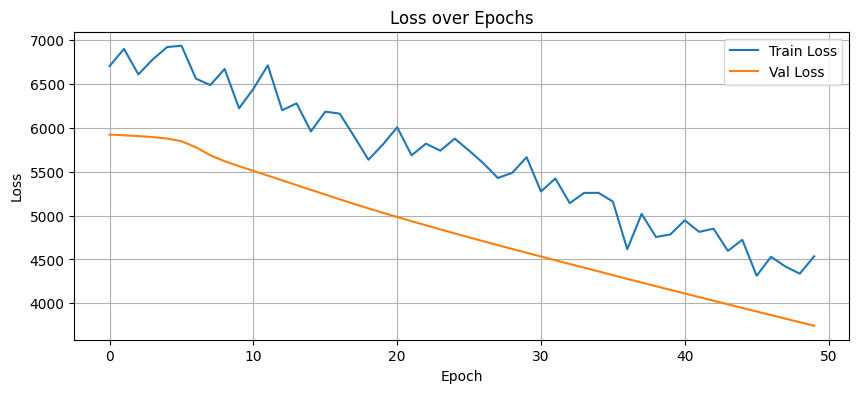

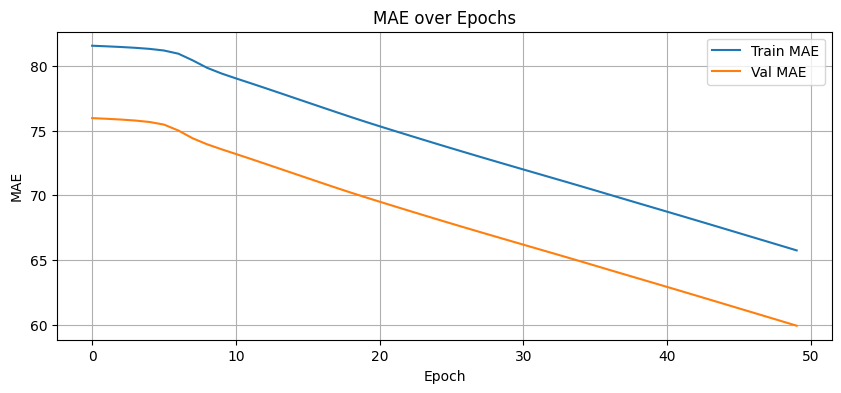

In [33]:
plt.figure(figsize=(10, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#MAE
plt.figure(figsize=(10, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


### MAE over Epochs: Model Performance Evaluation

The graph above shows the **Mean Absolute Error (MAE)** for both the training and validation sets across epochs.

- **Blue Line (Train MAE):**
  The training MAE consistently decreases over the epochs, indicating that the model is learning and fitting well to the training data.

- **Orange Line (Val MAE):**
  The validation MAE remains relatively stable in the first few epochs, but then starts to increase after epoch 5. This is a signal of **overfitting**, where the model continues to improve on training data but begins to generalise poorly on unseen validation data.

- **Insight:**
  Early stopping was triggered to avoid further overfitting. The **optimal model performance** appears to be around **epoch 3–4**, where both train and val MAE were relatively low and close.


## **EDA analysis**

## **Model Training & Evaluation**

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model.eval()
y_test_true, y_test_pred = [], []

with torch.no_grad():
    for x_seq, x_demo, y_true in test_loader:
        y_pred = model(x_seq, x_demo)
        y_test_true.extend(y_true.cpu().numpy())
        y_test_pred.extend(y_pred.cpu().numpy())

# Convert to numpy arrays
y_test_true = np.array(y_test_true).flatten()
y_test_pred = np.array(y_test_pred).flatten()

# Compute evaluation metrics
test_mae  = mean_absolute_error(y_test_true, y_test_pred)
test_r2   = r2_score(y_test_true, y_test_pred)

print(f"Test MAE : {test_mae:.4f}")
print(f"Test R²   : {test_r2:.4f}")


Test MAE : 62.9142
Test R²   : -16.1395


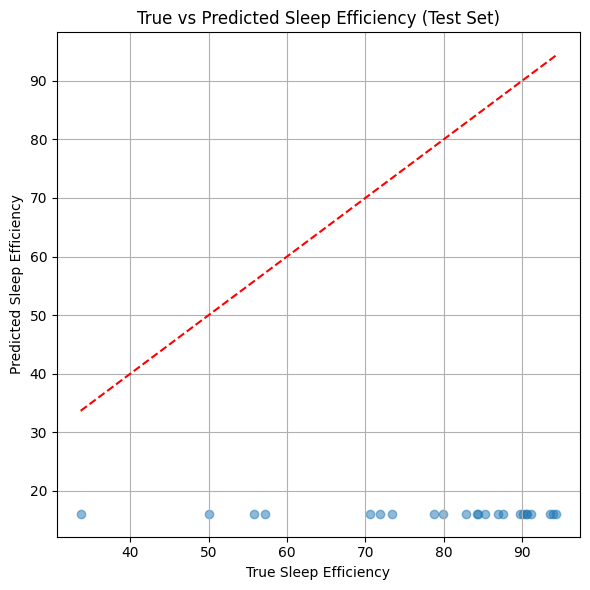

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_true, y_test_pred, alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--')
plt.xlabel("True Sleep Efficiency")
plt.ylabel("Predicted Sleep Efficiency")
plt.title("True vs Predicted Sleep Efficiency (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


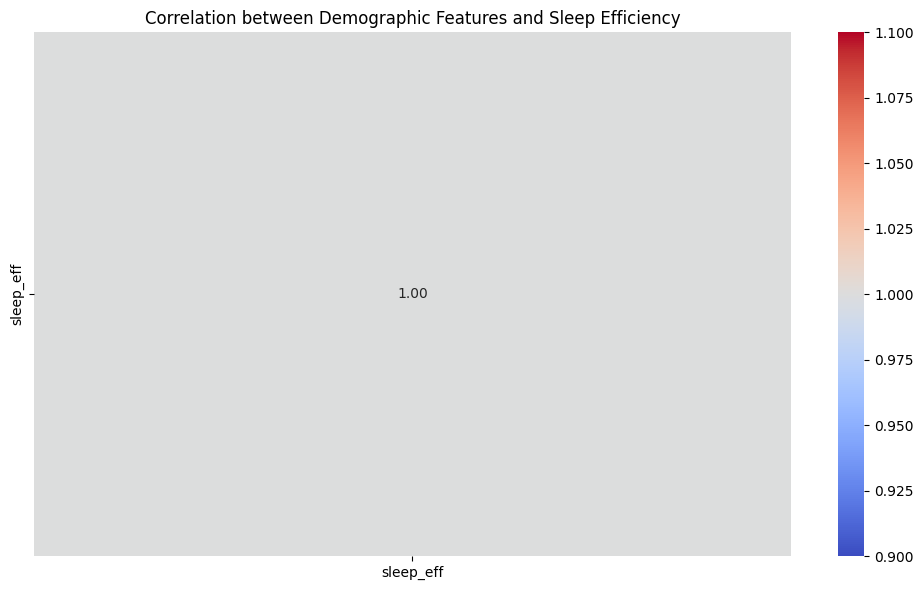

ValueError: at least one array or dtype is required

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# -------------------------------
# 1. Create DataFrame for demo features + target
demo_columns = [f'feat_{i}' for i in range(X_demo.shape[1])]

# -------------------------------
df_demo = pd.DataFrame(X_demo, columns=demo_columns)  # `demo_columns` from your preprocessing
df_demo['sleep_eff'] = y  # target sleep efficiency

# -------------------------------
# 2. Correlation Heatmap
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df_demo.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Demographic Features and Sleep Efficiency")
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Permutation Feature Importance
# -------------------------------
X = df_demo.drop(columns='sleep_eff')
y = df_demo['sleep_eff']

# Split for evaluation (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a basic model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculate permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, scoring='r2')

# Plot importance
importances = pd.Series(result.importances_mean, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6))
plt.title("Permutation Feature Importance (R² drop)")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()


In [ ]:
for i, name in enumerate(demo_columns):
    print(f"feat_{i}: {name}")


## **Summary**

## **Recommendations**